In [18]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([7.0, 8.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [20]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

In [21]:
# import pandas as pd

# def load_and_filter_annotation_data(annotation_path):
#     # Load the annotation data
#     annotation_data = pd.read_csv(annotation_path)
    
#     # Filter annotation data for video values 1.0 and 2.0
#     annotation_data = annotation_data[annotation_data['video'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])]
    
#     return annotation_data

# def load_physiological_data(physiological_path):
#     # Load the physiological data
#     physiological_data = pd.read_csv(physiological_path)
    
#     physiological_data = physiological_data[physiological_data['video'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])]
    
#     return physiological_data

# # Initialize empty DataFrames to hold all annotations and physiological data
# all_annotations = pd.DataFrame()
# all_physiological = pd.DataFrame()

# subjects = [5, 14, 21, 4, 9, 15, 16, 17, 19, 22]
# for subject in subjects:
#     print(f"Processing SUBJECT {subject}")
    
#     # Load and filter annotation data for the current subject
#     annotation_data = load_and_filter_annotation_data(
#         f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv'
#     )
    
#     # Load physiological data for the current subject
#     physiological_data = load_physiological_data(
#         f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv'
#     )
    
#     # Append the data to the respective DataFrames
#     all_annotations = pd.concat([all_annotations, annotation_data], ignore_index=True)
#     all_physiological = pd.concat([all_physiological, physiological_data], ignore_index=True)

# # Save the combined DataFrames to CSV files
# all_annotations.to_csv('C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/all_20-24_annotations_merged.csv', index=False)
# all_physiological.to_csv('C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/all_20-24_physiological_merged.csv', index=False)

# print("All subjects have been processed and merged into separate datasets.")

# # Categorize and save each video category in separate CSV files
# video_categories = {
#     "amusing": [1.0, 2.0],
#     "boring": [3.0, 4.0],
#     "relaxed": [5.0, 6.0],
#     "scary": [7.0, 8.0]
# }

# for category, videos in video_categories.items():
#     category_annotations = all_annotations[all_annotations['video'].isin(videos)]
#     category_physiological = all_physiological[all_physiological['video'].isin(videos)]
    
#     category_annotations.to_csv(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/{category}_annotations.csv', index=False)
#     category_physiological.to_csv(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/{category}_physiological.csv', index=False)

# print("Data has been categorized and saved into separate CSV files.")


Creating legend with loc="best" can be slow with large amounts of data.


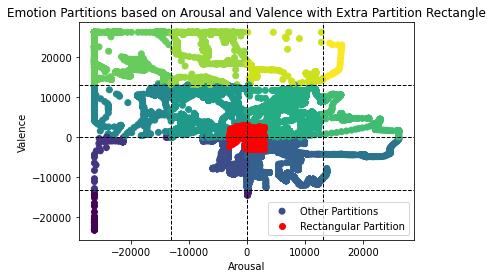

['Passionate or Amused' 'Frustrated or Impatient' 'Worried or Apathetic'
 'Frustrated or Discontented' 'Miserable or Sad' 'Anxious or Dejected'
 'Distressed or Defiant' 'Tensed or Annoyed' 'Aroused or Astonished'
 'Confident or Attentive' 'Delighted or Happy' 'Pleased or Glad'
 'Polite or Sleepy' 'Excited or Adventurous']
        valence  arousal  video_x                Emotion      ecg        bvp  \
3013      185.0   3136.0      8.0   Passionate or Amused  0.77704  36.583908   
3014      185.0   3136.0      8.0   Passionate or Amused  0.88876  36.293343   
3016      185.0   3136.0      8.0   Passionate or Amused  0.69820  35.954370   
3017      185.0   3136.0      8.0   Passionate or Amused  1.13516  36.612976   
3018      185.0   3252.0      8.0   Passionate or Amused  0.73104  36.051186   
...         ...      ...      ...                    ...      ...        ...   
208220 -26225.0  22572.0      8.0  Distressed or Defiant  0.79348  38.288617   
208221 -26225.0  22572.0      8.0  D

In [22]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/scary_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/scary_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





In [23]:
for i in range(100):
    if y_test[i]==7:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)

ecg          0.685060
bvp         37.019814
gsr         27.917568
rsp         42.245411
skt         34.371109
emg_zygo     5.316750
emg_coru     5.974000
emg_trap     9.834250
Name: 5133, dtype: float64
7
1
ecg          0.892040
bvp         36.312742
gsr         13.448352
rsp         30.029966
skt         23.264847
emg_zygo     4.824000
emg_coru     7.657750
emg_trap     5.891750
Name: 170097, dtype: float64
7
8
ecg          1.513000
bvp         32.903323
gsr         42.004488
rsp         43.503771
skt         34.805825
emg_zygo     5.152500
emg_coru     6.466750
emg_trap    10.532500
Name: 16650, dtype: float64
7
11
ecg          0.984040
bvp         37.310379
gsr         13.251240
rsp         30.184816
skt         23.278889
emg_zygo     4.947250
emg_coru     7.986250
emg_trap     5.891750
Name: 146873, dtype: float64
7
15
ecg          0.553640
bvp         36.022118
gsr         10.515096
rsp         36.621682
skt         20.165771
emg_zygo     5.604250
emg_coru     8.150500
emg_trap   

TIME to interpret

 114.74592757225037 seconds


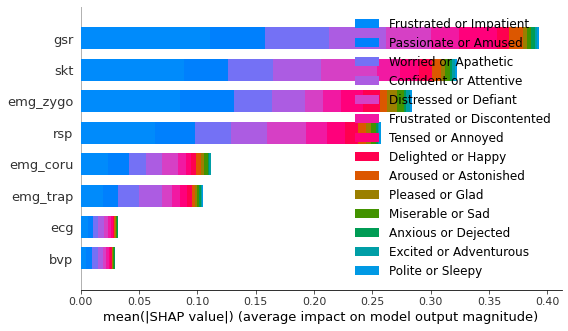

In [24]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


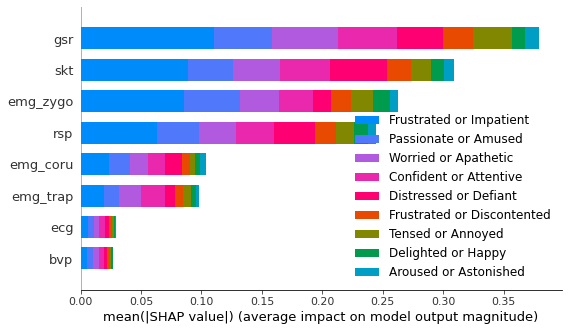

In [25]:
# Step 1: Sum the absolute SHAP values across features for each class
class_sums = np.sum(np.abs(shap_values_RF_test), axis=(1, 2))

# Step 2: Get the indices of the top N classes
top_class_indices = np.argsort(class_sums)[-9:]  # Change 6 to the number of classes you want to display

# Step 3: Select the SHAP values and class names for these top classes
shap_values_top_classes = [shap_values_RF_test[i] for i in top_class_indices]
class_names_top = [class_names[i] for i in top_class_indices]

# Step 4: Create the summary plot for the top classes
shap.summary_plot(shap_values_top_classes, X_test[0:100], class_names=class_names_top)


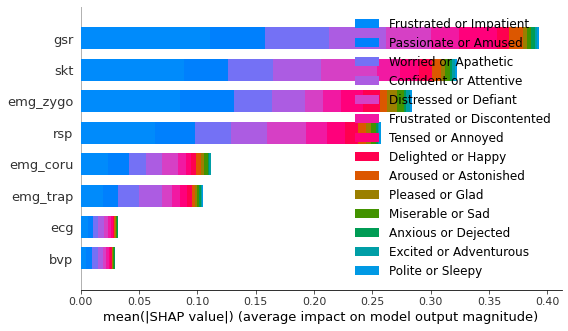

In [26]:
shap.summary_plot(shap_values_RF_test, X_test[0:100],class_names=class_names)

In [27]:
y_test

array([ 9,  7, 12, ...,  1,  9,  7])

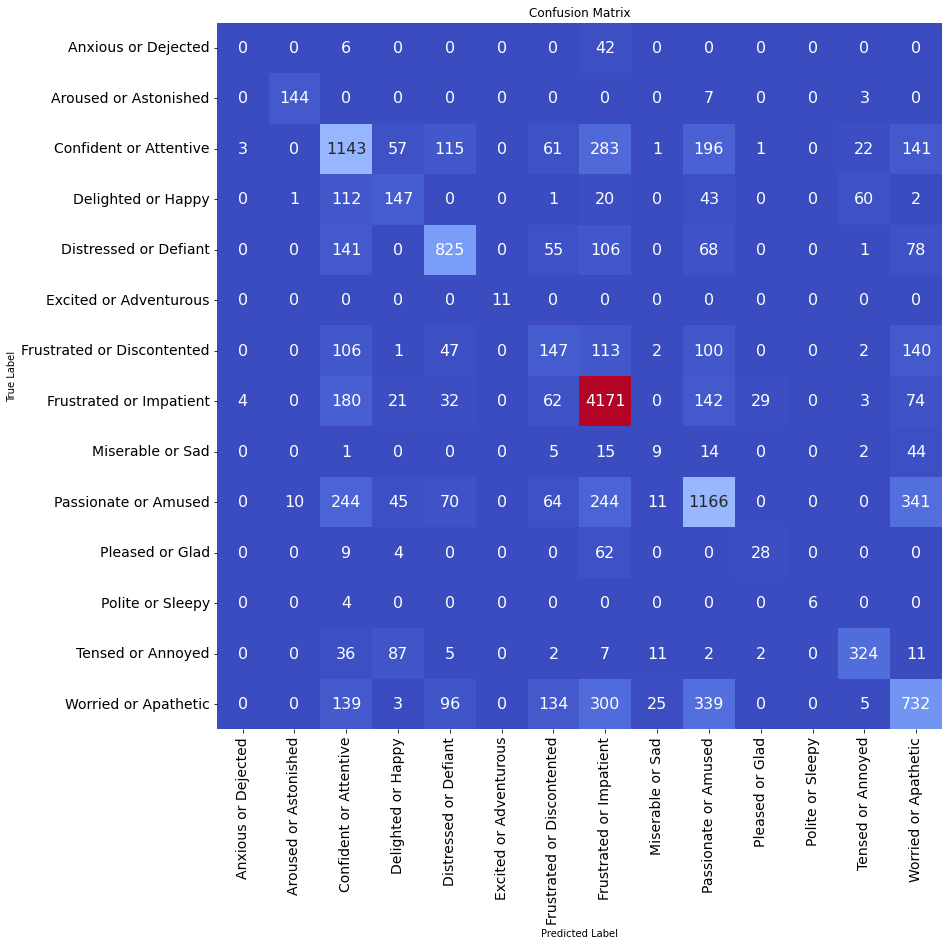

<Figure size 432x288 with 0 Axes>

In [28]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.6355348169418521


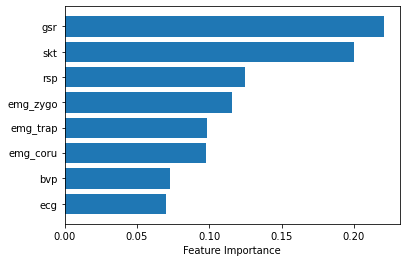

In [29]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [31]:
len(class_names)

14

In [32]:
instance_index = 8
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.892040
bvp         36.312742
gsr         13.448352
rsp         30.029966
skt         23.264847
emg_zygo     4.824000
emg_coru     7.657750
emg_trap     5.891750
Name: 170097, dtype: float64
Frustrated or Impatient
Anxious or Dejected
[ 5.40865771e-05 -2.10058343e-04  2.04852536e-04  7.60338123e-04
  1.08666215e-03 -6.51536134e-03 -5.01235374e-04  2.12886384e-03]
Aroused or Astonished
[-0.00038019 -0.00016388 -0.00660511  0.0007875  -0.00219028 -0.00323135
 -0.00282616  0.00243943]
Confident or Attentive
[ 0.00185503 -0.00064012 -0.04328498  0.01163355 -0.01566624 -0.04911139
  0.00333405 -0.01589352]
Delighted or Happy
[-0.00017394  0.00018498 -0.00728462 -0.00385681 -0.00443798 -0.01060534
 -0.00043363 -0.00052555]
Distressed or Defiant
[-0.00893948 -0.00246809 -0.01546294 -0.01581971 -0.00659918 -0.01962699
  0.01707615  0.00650012]
Excited or Adventurous
[ 2.88091482e-05  1.19944265e-06  9.32193517e-05 -4.44280615e-05
 -2.14913608e-04 -1.27363934e-03  2.58131718e-04  

In [36]:
colour_scheme = 'cool'

FOR  Anxious or Dejected


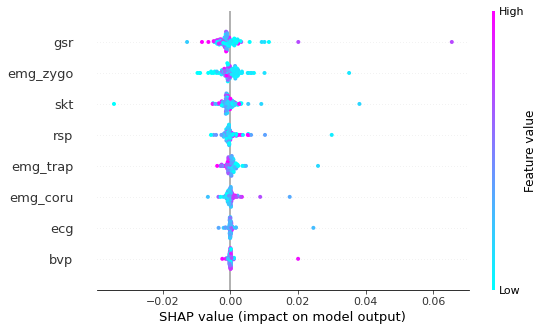

<Figure size 432x288 with 0 Axes>

FOR  Aroused or Astonished


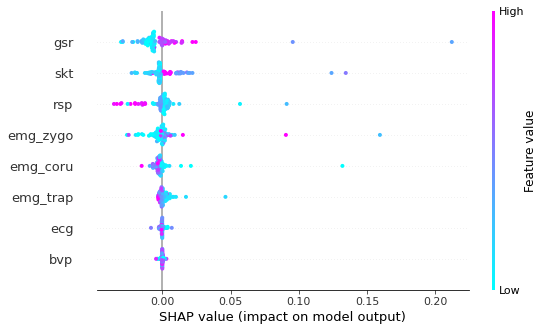

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


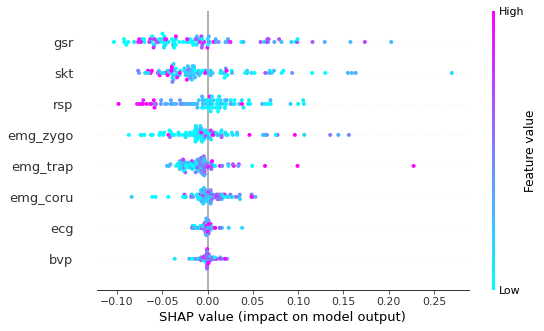

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


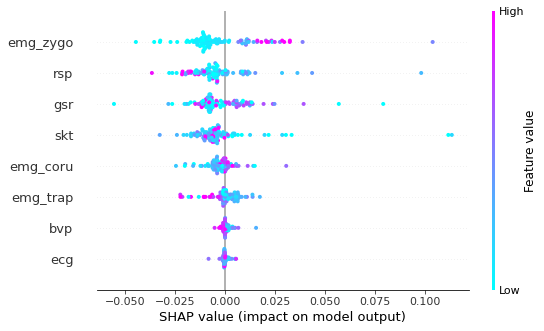

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


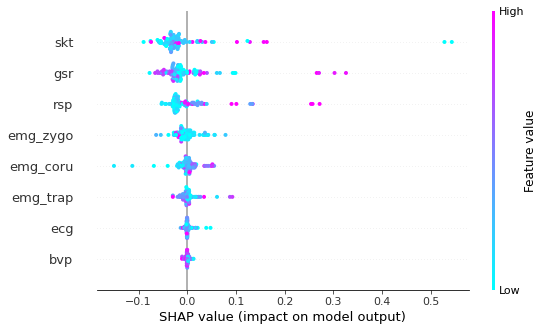

<Figure size 432x288 with 0 Axes>

FOR  Excited or Adventurous


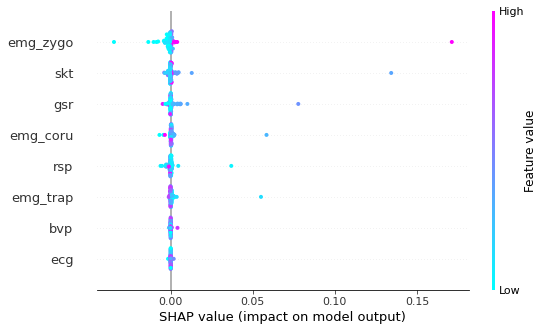

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


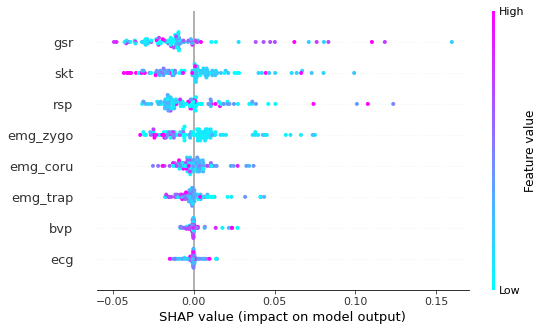

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


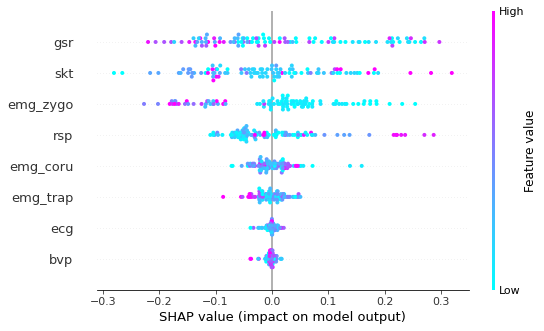

<Figure size 432x288 with 0 Axes>

FOR  Miserable or Sad


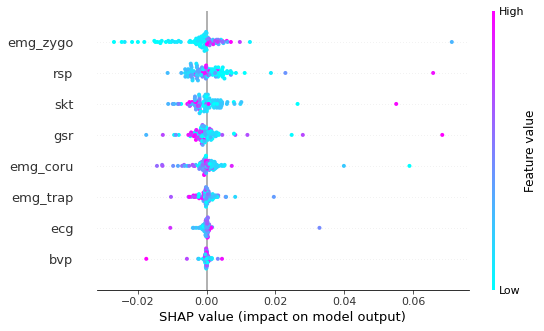

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


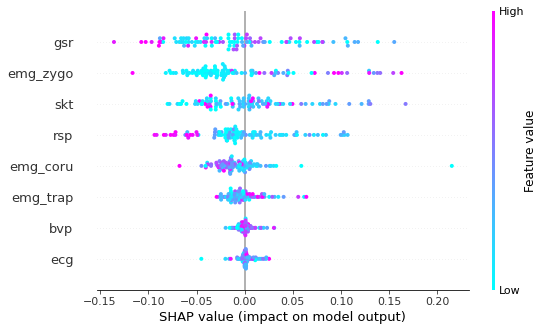

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


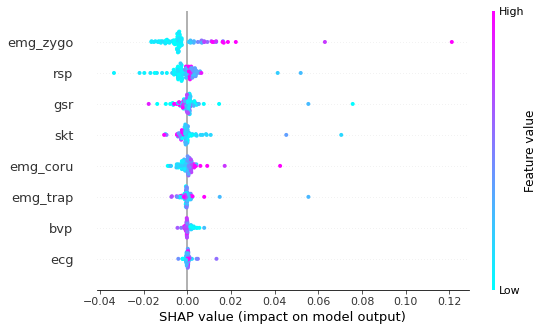

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


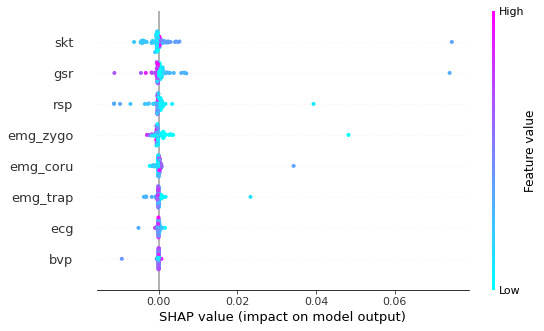

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


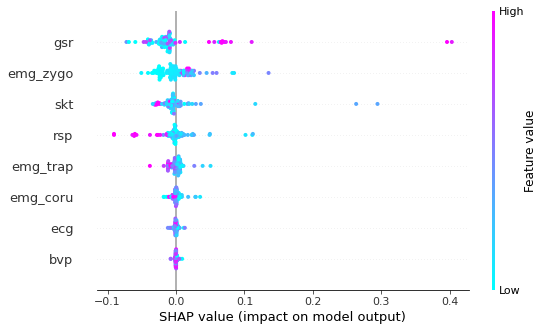

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


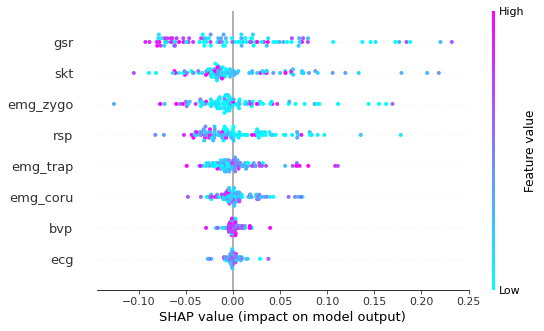

<Figure size 432x288 with 0 Axes>

In [37]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Anxious or Dejected


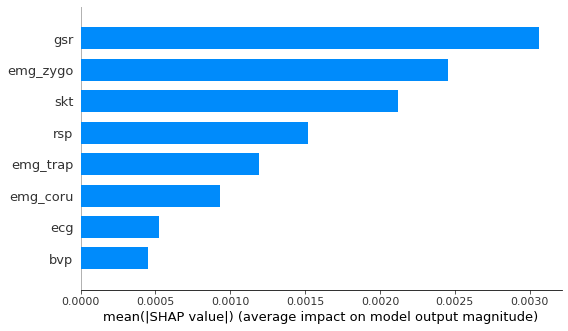

FOR  Aroused or Astonished


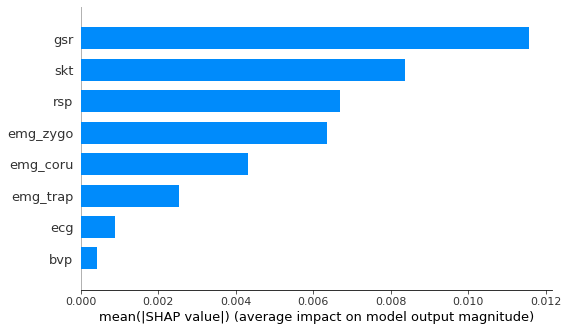

FOR  Confident or Attentive


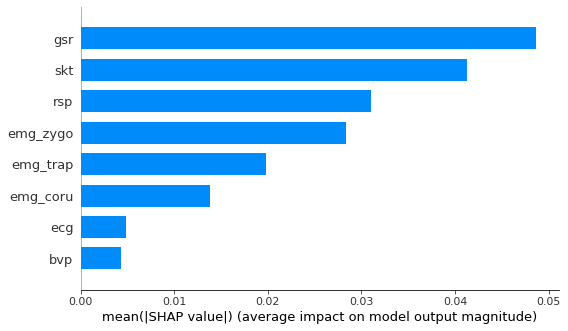

FOR  Delighted or Happy


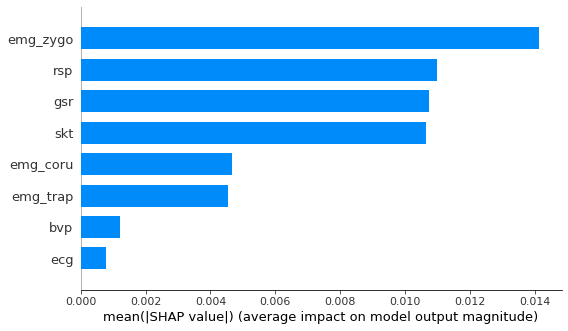

FOR  Distressed or Defiant


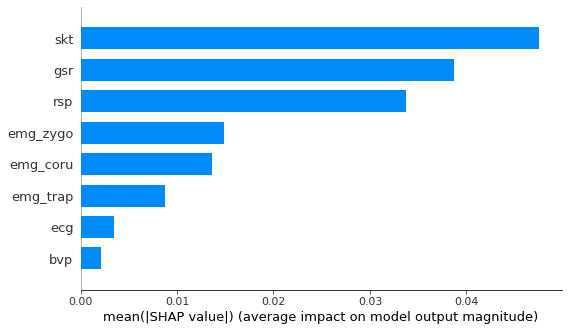

FOR  Excited or Adventurous


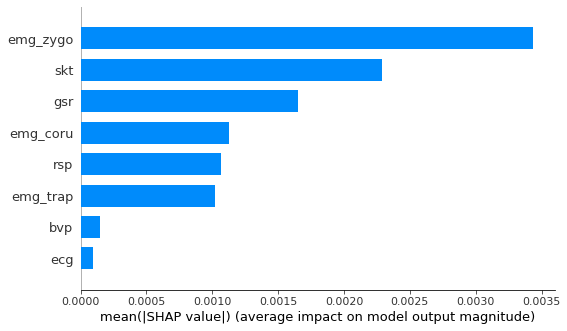

FOR  Frustrated or Discontented


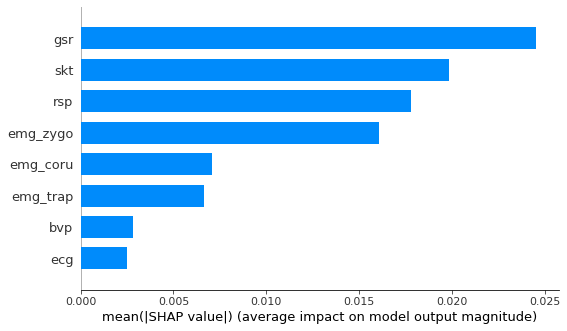

FOR  Frustrated or Impatient


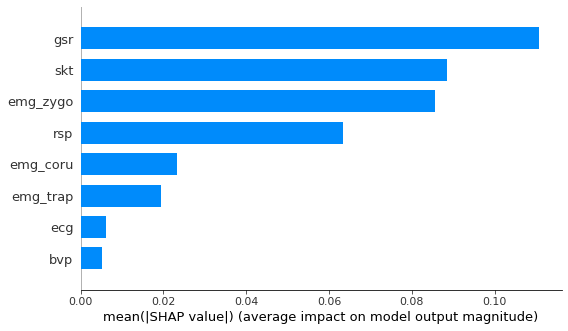

FOR  Miserable or Sad


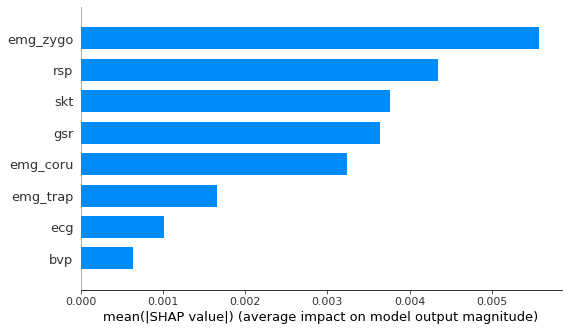

FOR  Passionate or Amused


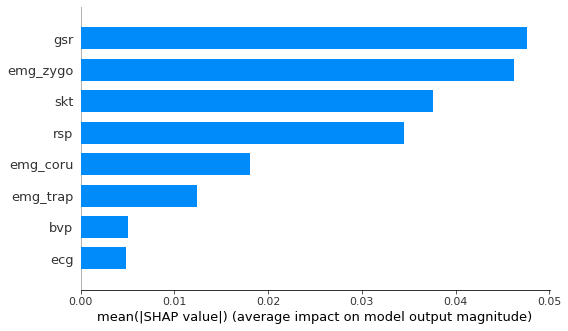

FOR  Pleased or Glad


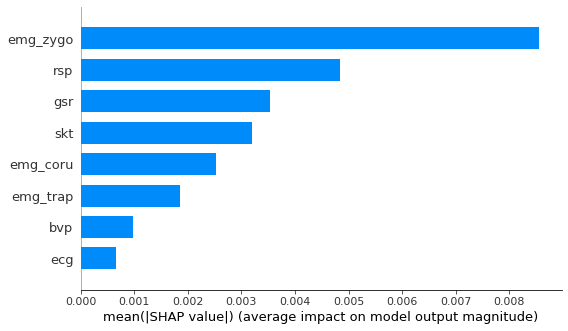

FOR  Polite or Sleepy


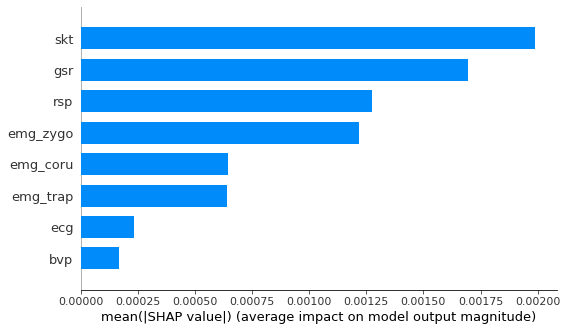

FOR  Tensed or Annoyed


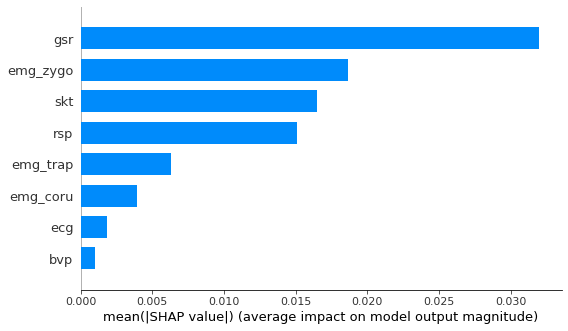

FOR  Worried or Apathetic


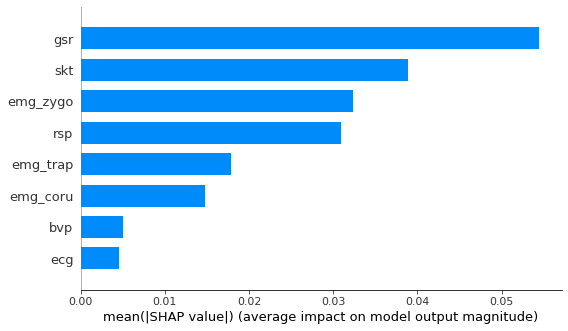

<Figure size 432x288 with 0 Axes>

In [38]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [93]:
shap.initjs()
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.763900
bvp         36.719520
gsr         11.003976
rsp         36.060264
skt         19.990497
emg_zygo     6.056000
emg_coru     6.220250
emg_trap     8.889750
Name: 17926, dtype: float64
Frustrated or Impatient
CLASS  Anxious or Dejected


CLASS  Anxious or Dejected


CLASS  Aroused or Astonished


CLASS  Aroused or Astonished


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Excited or Adventurous


CLASS  Excited or Adventurous


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Miserable or Sad


CLASS  Miserable or Sad


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Pleased or Glad


CLASS  Pleased or Glad


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Tensed or Annoyed


CLASS  Tensed or Annoyed


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [56]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

57.658249378204346


In [57]:
explanation[5]

.values =
array([[-3.30037015e-04, -1.90002194e-04, -7.44261841e-04,
        -1.88103903e-04, -1.30569741e-04,  9.15780348e-06,
        -9.67906514e-04,  1.84165669e-04, -1.45811625e-04,
        -3.18590423e-04,  2.76281272e-04, -8.00226307e-05,
         3.30873552e-03, -6.83034380e-04],
       [-7.61425150e-05, -6.28077472e-04,  4.88261387e-04,
         9.18620152e-04,  3.00200303e-03, -2.66506450e-05,
        -5.13574315e-04, -3.24245331e-03, -6.71866412e-05,
         4.04914124e-04,  3.75673411e-04, -1.23648394e-05,
         3.74552045e-04, -9.97574413e-04],
       [-1.60322572e-03,  9.08377027e-03, -3.50579246e-02,
        -1.05998759e-02,  3.25988400e-01, -2.67995288e-04,
        -1.39507985e-02, -2.19623190e-01, -1.83696688e-03,
        -5.04179816e-02, -3.52436834e-03, -3.10494956e-04,
         8.02013333e-02, -7.80806820e-02],
       [ 9.82665481e-04, -2.33329558e-02, -6.74178498e-02,
        -6.19217652e-03,  2.57364758e-01, -2.78639565e-04,
        -3.38200190e-03, -1.5422138

In [58]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
192745  0.89204  36.196468  18.356832  33.330656  25.494512   5.11150   
5133    0.68506  37.019814  27.917568  42.245411  34.371109   5.31675   
107352  0.78362  34.985743  36.216744  31.568976  25.056296   5.76850   
104954  0.78690  35.934972  19.575096  31.191515  25.105380   4.90625   
177943  0.82632  35.683145  10.467792  35.682744  20.130729   5.48125   
...         ...        ...        ...        ...        ...       ...   
175523  0.84276  36.041516  42.962544  49.901925  33.981956   7.69875   
87920  -0.03776  35.789690   8.090448  33.833976  22.458541   7.16500   
108374  0.76390  35.305376  46.684392  32.178829  24.965148   5.19375   
191443  0.86576  35.663747  18.967944  33.514555  25.540096   4.90625   
146439  0.96104  37.862440  25.831944  42.932689  34.311503   5.56325   

        emg_coru  emg_trap  
192745   6.05600   9.17725  
5133     5.97400   9.83425  
107352   6.79525   7.32925  
104954 

In [50]:
for i in range(100):
    if y_test[i]==7:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)

ecg          0.685060
bvp         37.019814
gsr         27.917568
rsp         42.245411
skt         34.371109
emg_zygo     5.316750
emg_coru     5.974000
emg_trap     9.834250
Name: 5133, dtype: float64
7
1
ecg          0.892040
bvp         36.312742
gsr         13.448352
rsp         30.029966
skt         23.264847
emg_zygo     4.824000
emg_coru     7.657750
emg_trap     5.891750
Name: 170097, dtype: float64
7
8
ecg          1.513000
bvp         32.903323
gsr         42.004488
rsp         43.503771
skt         34.805825
emg_zygo     5.152500
emg_coru     6.466750
emg_trap    10.532500
Name: 16650, dtype: float64
7
11
ecg          0.984040
bvp         37.310379
gsr         13.251240
rsp         30.184816
skt         23.278889
emg_zygo     4.947250
emg_coru     7.986250
emg_trap     5.891750
Name: 146873, dtype: float64
7
15
ecg          0.553640
bvp         36.022118
gsr         10.515096
rsp         36.621682
skt         20.165771
emg_zygo     5.604250
emg_coru     8.150500
emg_trap   

CLASS NAME  Anxious or Dejected


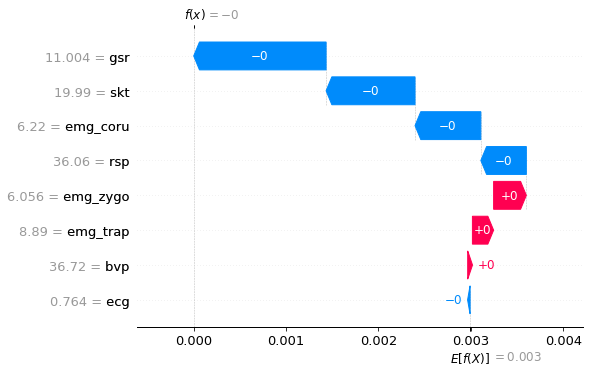

CLASS NAME  Aroused or Astonished


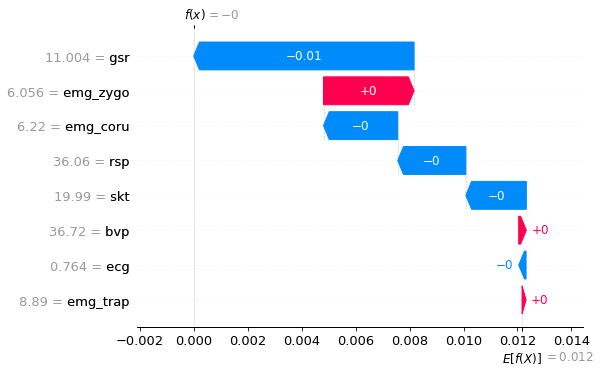

CLASS NAME  Confident or Attentive


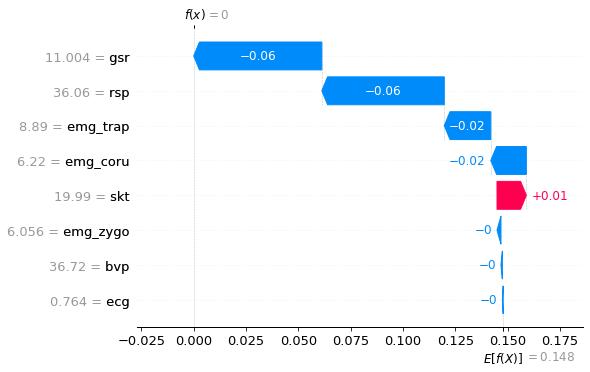

CLASS NAME  Delighted or Happy


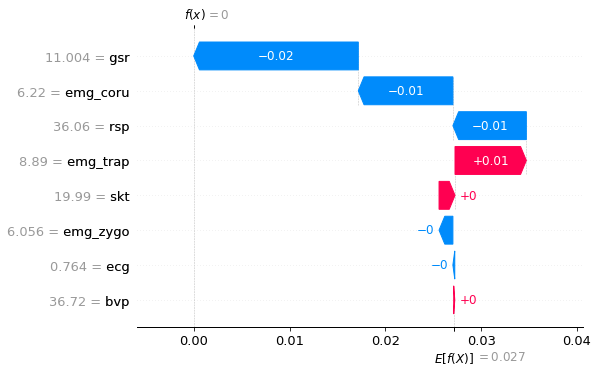

CLASS NAME  Distressed or Defiant


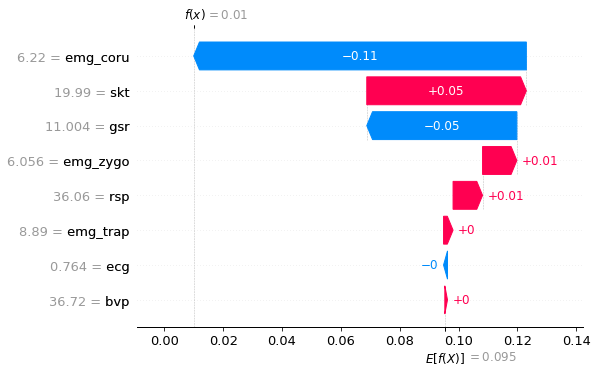

CLASS NAME  Excited or Adventurous


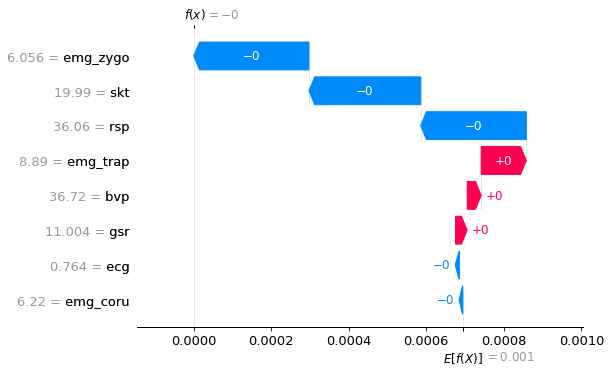

CLASS NAME  Frustrated or Discontented


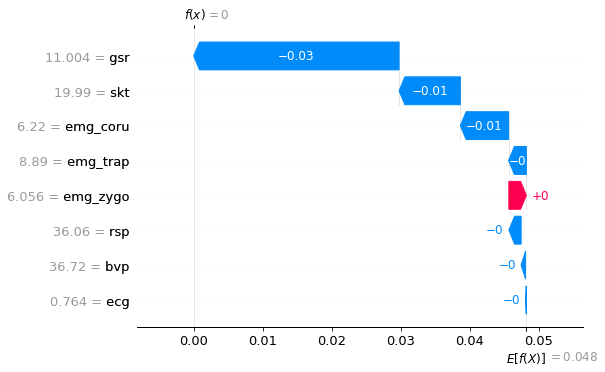

CLASS NAME  Frustrated or Impatient


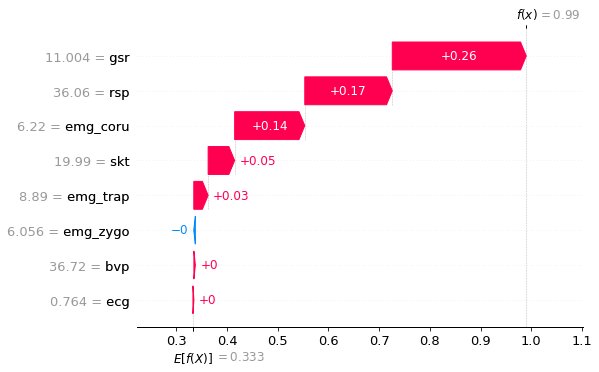

CLASS NAME  Miserable or Sad


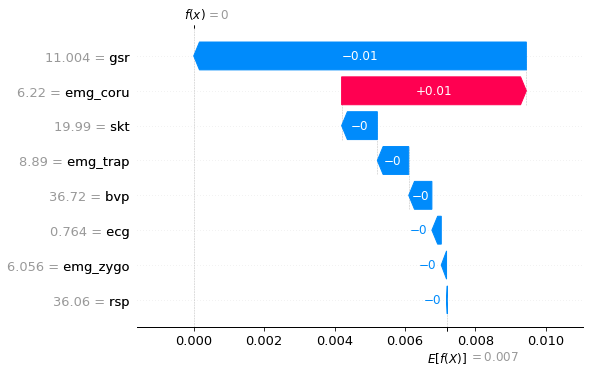

CLASS NAME  Passionate or Amused


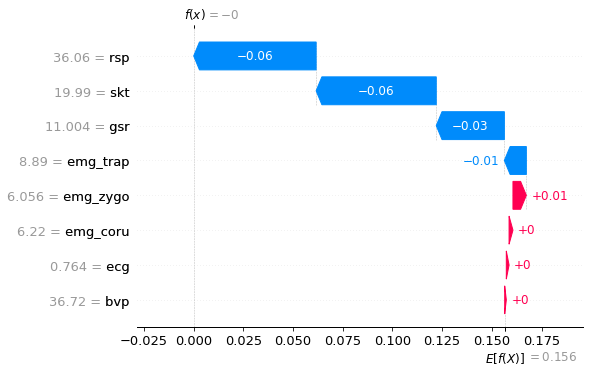

CLASS NAME  Pleased or Glad


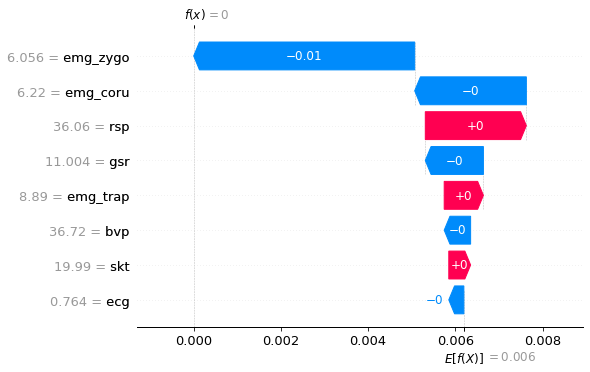

CLASS NAME  Polite or Sleepy


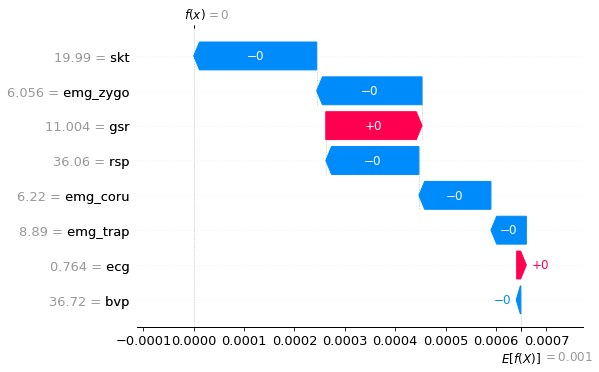

CLASS NAME  Tensed or Annoyed


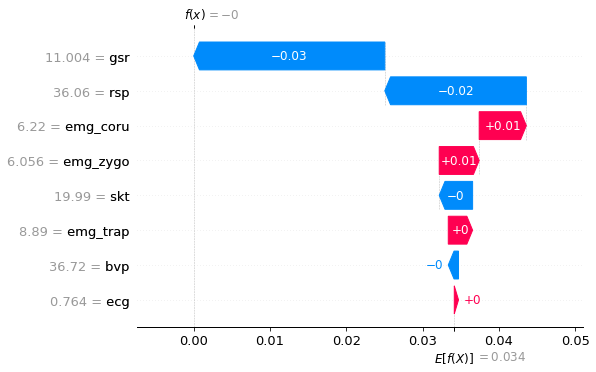

CLASS NAME  Worried or Apathetic


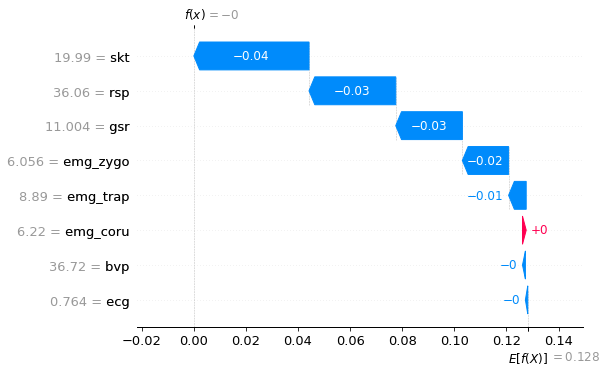

In [89]:
instance_index = 29
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [90]:
class_names[y_test[instance_index]]

'Frustrated or Impatient'

In [91]:
X_test.iloc[instance_index]

ecg          0.763900
bvp         36.719520
gsr         11.003976
rsp         36.060264
skt         19.990497
emg_zygo     6.056000
emg_coru     6.220250
emg_trap     8.889750
Name: 17926, dtype: float64

CLASS  Anxious or Dejected


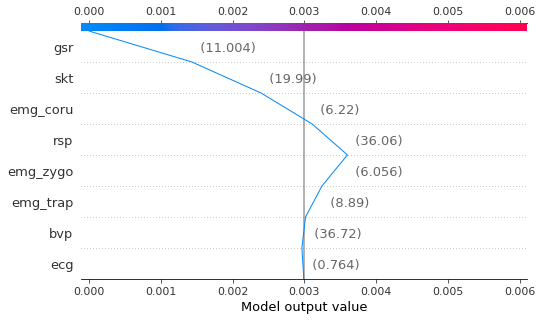

CLASS  Aroused or Astonished


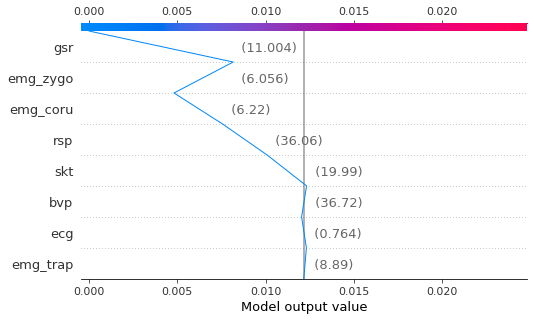

CLASS  Confident or Attentive


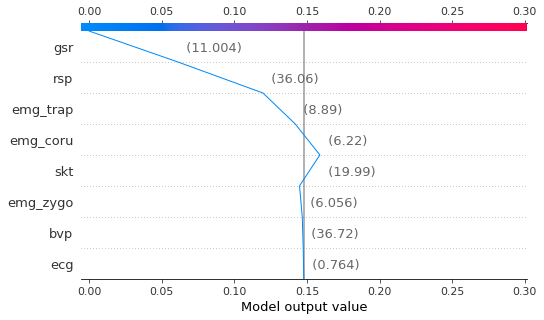

CLASS  Delighted or Happy


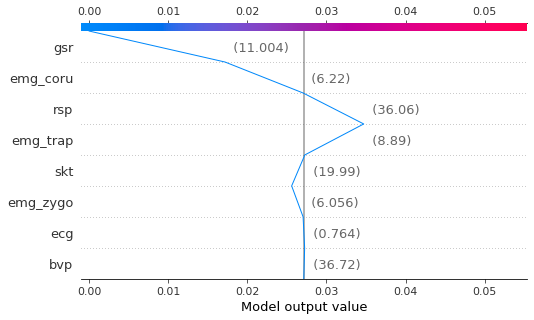

CLASS  Distressed or Defiant


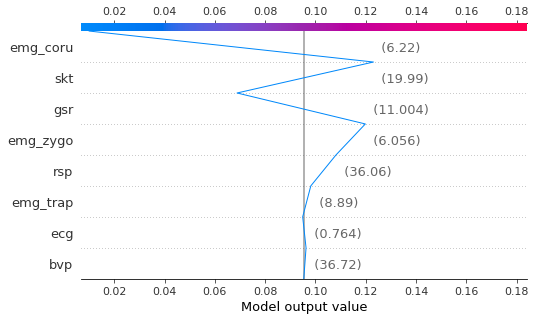

CLASS  Excited or Adventurous


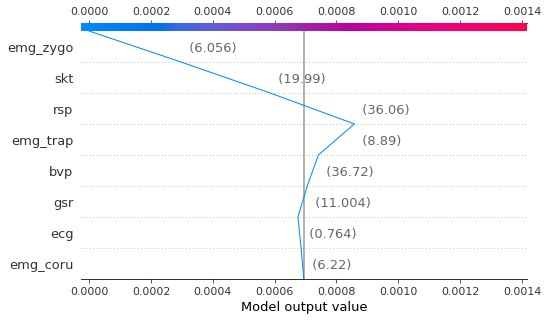

CLASS  Frustrated or Discontented


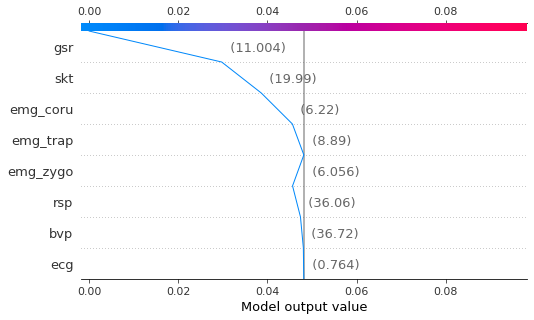

CLASS  Frustrated or Impatient


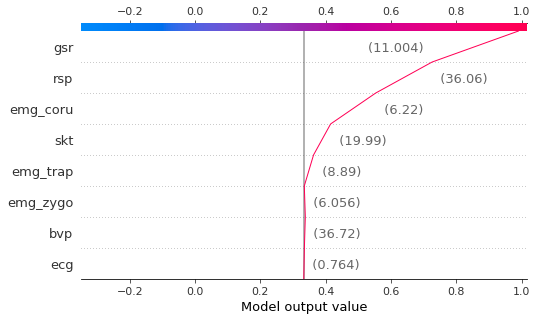

CLASS  Miserable or Sad


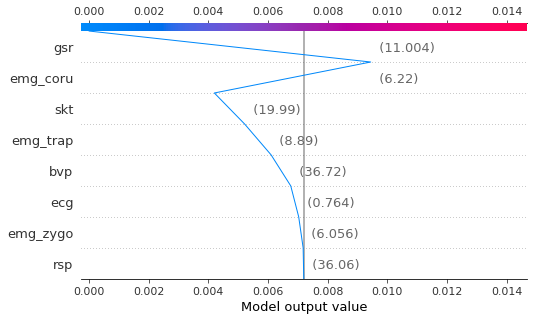

CLASS  Passionate or Amused


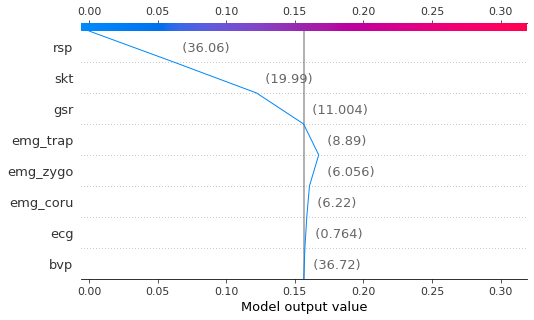

CLASS  Pleased or Glad


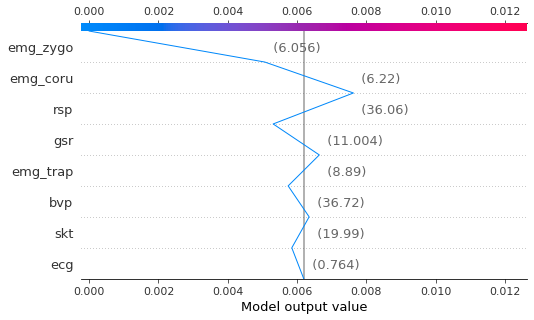

CLASS  Polite or Sleepy


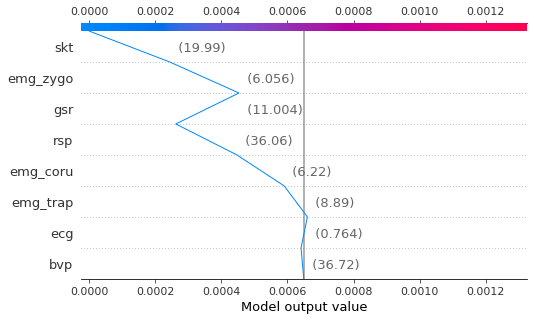

CLASS  Tensed or Annoyed


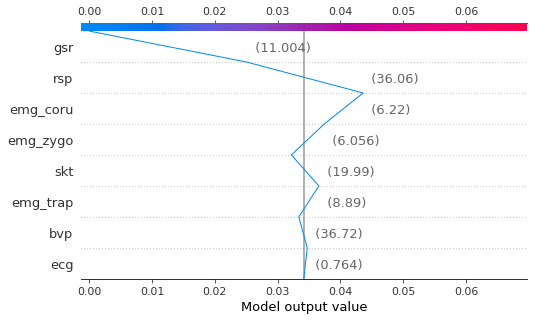

CLASS  Worried or Apathetic


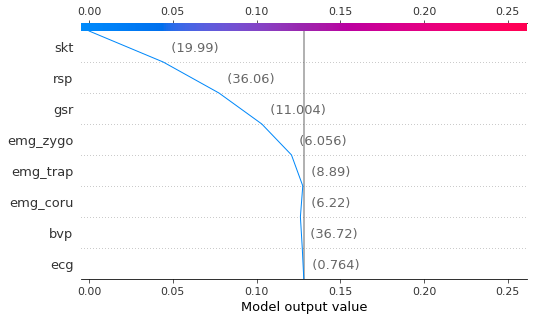

In [92]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [47]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 7.849629878997803 seconds


In [48]:
explanation = explanations_test[0]
explanation.show_in_notebook()

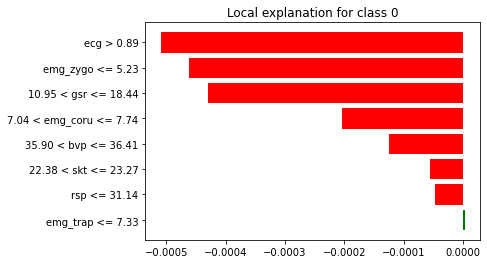

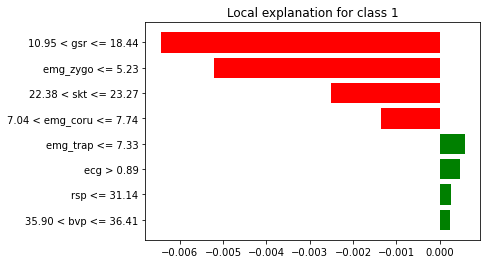

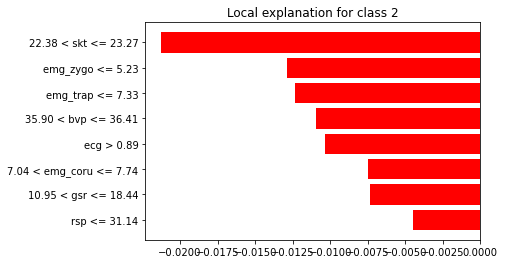

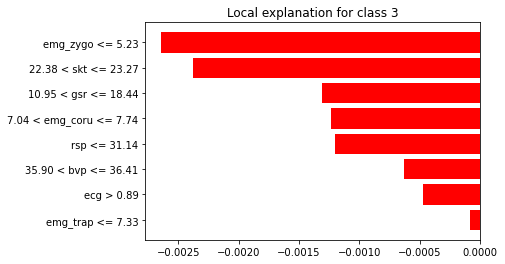

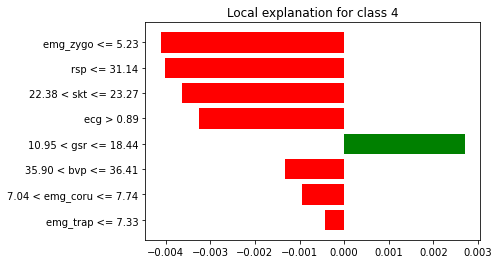

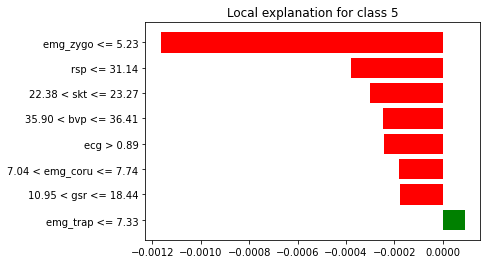

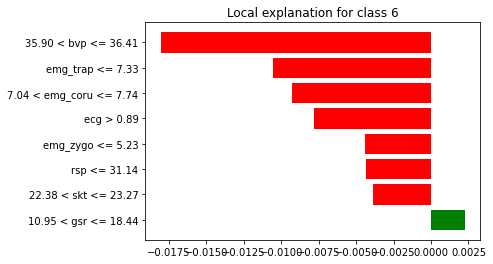

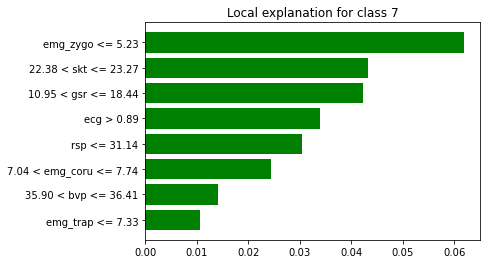

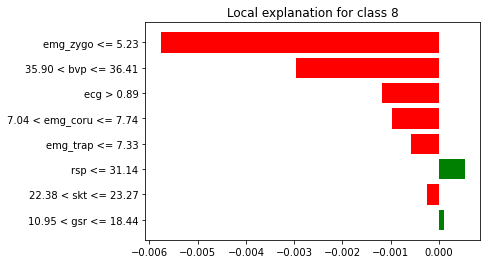

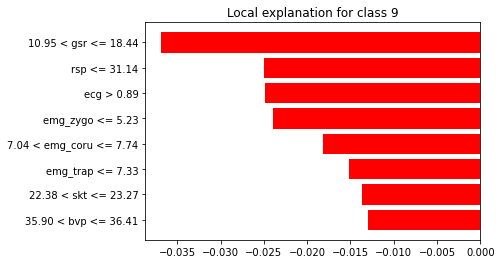

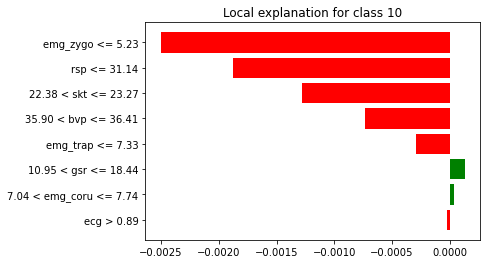

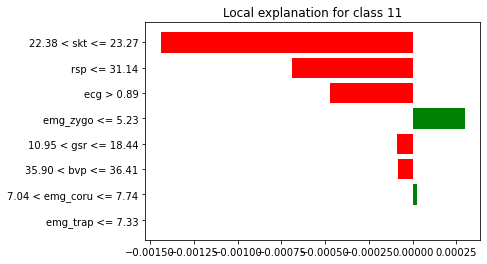

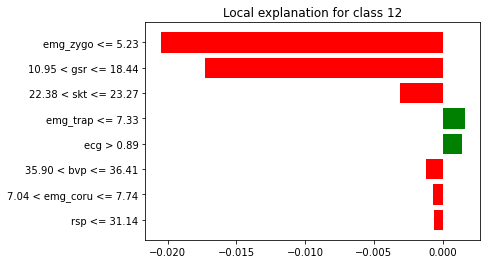

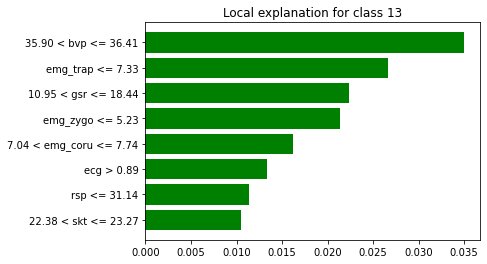

In [49]:
for i in range(len(encoded_classes)):
    explanation.as_pyplot_figure(label=i)